# **Convolutional VAE with Anime Faces Dataset**

### **Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from google.colab import drive
from IPython import display
from tqdm import tqdm
import os
import glob
import imageio.v2 as imageio

### **Parameters**

In [2]:
epochs = 25
z_dim = 16
batch_size = 128
buffer_size = 1024
resize = (64, 64)
AUTOTUNE = tf.data.AUTOTUNE

### **Load and Preprocess the Dataset**

In [4]:
data_url = "https://storage.googleapis.com/learning-datasets/Resources/anime-faces.zip"

# Download dataset
!wget -q $data_url  -O /content/anime_faces.zip

# Unzip the dataset
!unzip -q /content/anime_faces.zip -d /content/anime_faces

In [3]:
def preprocessing(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, resize)
  img = tf.cast(img, tf.float32)/255
  return img

In [29]:
train_dataset = tf.data.Dataset.list_files("/content/anime_faces/images/*jpg", shuffle=False)
train_dataset = (train_dataset
                 .map(preprocessing, num_parallel_calls=AUTOTUNE)
                 .shuffle(buffer_size, seed=123)
                 .batch(batch_size)
                 .prefetch(AUTOTUNE))

In [23]:
for im in train_dataset.take(1):
  print(im.shape)

(128, 64, 64, 3)


In [24]:
im.numpy().min(), im.numpy().max()

(0.0, 1.0)

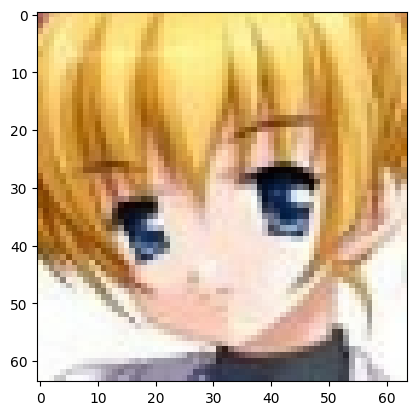

In [25]:
plt.imshow(im[0]);

### **Build the Model**

The "Sampling" class will be created. This will be a custom Keras layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon $$

where $\mu$ = mean, $\sigma$ = standard deviation and $\epsilon$ = random sample

In [8]:
tf.keras.backend.clear_session()

In [9]:
@tf.keras.saving.register_keras_serializable()
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon
    z = tf.reshape(z, (batch, 1, 1, dim))

    return z

**Encoder**

In [10]:
def build_encoder():

  input = tf.keras.Input((64, 64, 3))
  x = tf.keras.layers.Conv2D(64, (4,4), strides=2, padding="same")(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU(0.2)(x)

  x = tf.keras.layers.Conv2D(128, (4,4), strides=2, padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU(0.2)(x)

  x = tf.keras.layers.Conv2D(256, (4,4), strides=2, padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU(0.2)(x)

  x = tf.keras.layers.Conv2D(512, (4,4), strides=2, padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU(0.2)(x)

  mu = tf.keras.layers.Conv2D(z_dim, (4,4), strides=1)(x)
  mu = tf.keras.layers.Flatten()(mu)

  sigma = tf.keras.layers.Conv2D(z_dim, (4,4), strides=1)(x)
  sigma = tf.keras.layers.Flatten()(sigma)

  z = Sampling()([mu, sigma])

  model = tf.keras.Model(inputs=input, outputs=[mu, sigma, z], name="encoder")

  return model

In [11]:
tf.random.set_seed(123) # for reproducibility

encoder = build_encoder()
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           3136      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

**Decoder**

In [12]:
def build_decoder():

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(512, (4,4), strides=1, padding="valid", input_shape=(1, 1, z_dim)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.ReLU(),

      tf.keras.layers.Conv2DTranspose(256, (4,4), strides=2, padding="same"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.ReLU(),

      tf.keras.layers.Conv2DTranspose(128, (4,4), strides=2, padding="same"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),

      tf.keras.layers.Conv2DTranspose(64, (4,4), strides=2, padding="same"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),

      tf.keras.layers.Conv2DTranspose(3, (4,4), strides=2, padding="same", activation="sigmoid")
  ], name="decoder")

  return model

In [13]:
tf.random.set_seed(123) # for reproducibility

decoder = build_decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         131584    
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097408   
 Transpose)                                                      
                                                           

**Kullback–Leibler Divergence**

To improve the generative capacity of the model, the random normal distribution introduced in the latent space must be taken into account. To do this, the [Kullback-Leibler Divergence](https://arxiv.org/abs/2002.07514) is calculated and will be added to the reconstruction loss. The formula is defined in the following function:

In [14]:
def kl_divergence_loss(mu, sigma):
  kl_loss = 1 + sigma - tf.square(mu) - tf.exp(sigma)
  kl_loss = -0.5 * tf.reduce_mean(kl_loss)

  return kl_loss

**VAE**

In [15]:
def build_vae():
  input = tf.keras.layers.Input((64, 64, 3))
  mu, sigma, z = encoder(input)
  x = decoder(z)

  model = tf.keras.Model(inputs=input, outputs=x)

  # Adding the Kullback–Leibler Divergence loss to the model
  kl_loss = kl_divergence_loss(mu, sigma)
  model.add_loss(kl_loss)

  return model

In [16]:
vae = build_vae()
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 16),                 3022560   ['input_2[0][0]']             
                              (None, 16),                                                         
                              (None, 1, 1, 16)]                                                   
                                                                                                  
 decoder (Sequential)        (None, 64, 64, 3)            2891459   ['encoder[0][2]']             
                                                                                              

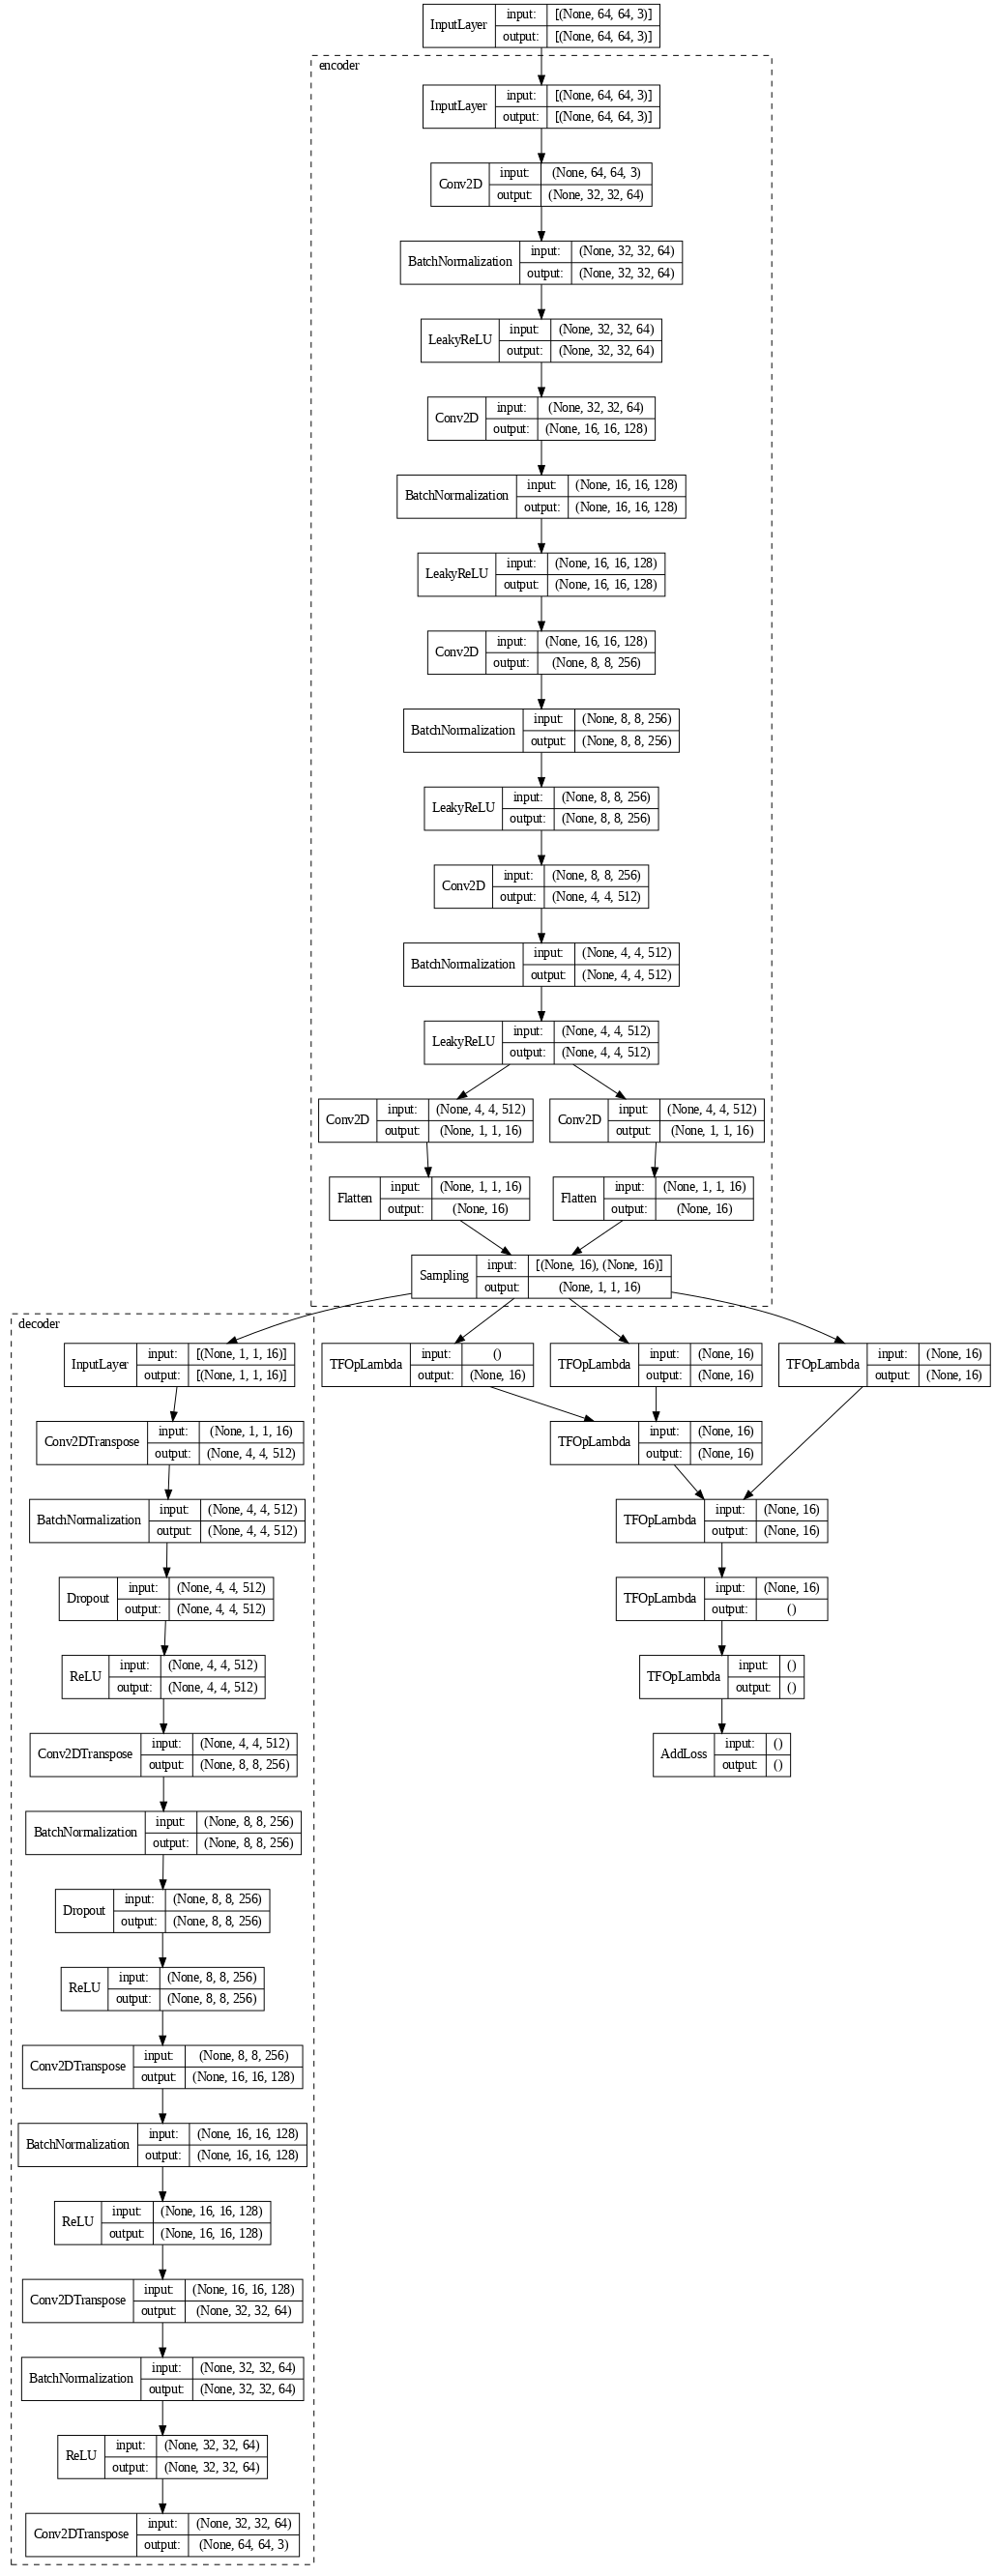

In [17]:
# Visualizing the architecture of the VAE model
tf.keras.utils.plot_model(vae, show_shapes=True, show_layer_names=False, expand_nested=True, dpi=70)

### **Train the Model**

**Utilities**

In [21]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [18]:
# Images directory
directory_images = "/content/drive/MyDrive/images"
directory_vae = os.path.join(directory_images, "vae_anime_faces")

os.makedirs(directory_vae, exist_ok=True)

In [14]:
# Display functions

def make_grid(images, num_examples, nrow):
  images=tf.unstack(images[:num_examples], axis=0)
  images=tf.concat(images, axis=1)
  images=tf.split(images, nrow, axis=1)
  images=tf.concat(images, axis=0)

  return images

def show_and_save_images(real_images, fake_images, num_examples, nrow,
                         epoch=0, save=False, random=False, names=["", ""]):

  indices = np.arange(len(fake_images))
  if random:
    np.random.shuffle(indices)

  real_images = make_grid(real_images.numpy()[indices], num_examples, nrow)
  fake_images = make_grid(fake_images.numpy()[indices], num_examples, nrow)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(real_images)
  ax[0].axis("off")
  ax[0].set_title(names[0])
  ax[1].imshow(fake_images)
  ax[1].axis("off")
  ax[1].set_title(names[1])

  plt.show()

  # Save fake images
  if save:
    plt.imshow(fake_images)
    plt.axis("off")
    plt.savefig(os.path.join(directory_vae, f"image{epoch:02d}.png"), transparent=True)
    plt.close()

**Generate random images to create the GIF**

In [20]:
tf.random.set_seed(123) #for the reproducibility of noise tensor
num_examples = 25
nrow = 5

noise = tf.random.normal((num_examples, 1, 1, z_dim))
fake_images = decoder(noise, training=False)

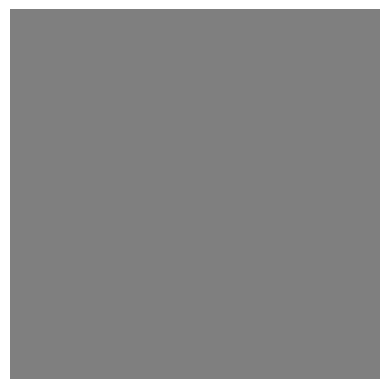

In [21]:
# Image of epoch 0

fake_images = make_grid(fake_images, num_examples, nrow)
plt.imshow(fake_images)
plt.axis("off")
plt.savefig(os.path.join(directory_vae, f"image{0:02d}.png"), transparent=True);

**Optimizer and Reconstruction Loss**

The multiplication factor of 4096 in `recons_loss` adjusts the pixel reconstruction error to the total error per image in a VAE model trained on the Anine Faces dataset, where its images have dimensions (64, 64, 3), equivalent to 4096 pixels per channel.

In [22]:
optimizer = tf.keras.optimizers.Adam(2e-4)
recons_loss = tf.keras.losses.MeanSquaredError()

**Function for training at each step**

In [23]:
@tf.function
def train_step(real_images):

  with tf.GradientTape() as tape:
    recons_images = vae(real_images, training=True)
    # VAE losses: Reconstructed loss + KL divergence loss
    loss = recons_loss(real_images, recons_images) * 4096 + sum(vae.losses)

  gradients = tape.gradient(loss, vae.trainable_variables)
  optimizer.apply_gradients(zip(gradients, vae.trainable_variables))

  return loss

**Training function**

In [24]:
def train_vae(epochs=epochs, num_examples=num_examples, nrow=nrow):
  history={"loss":[]}

  for epoch in range(epochs):
    loss_list = []

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}/{epochs}]")
      for real_images in pbar:
        loss = train_step(real_images)

        loss_list.append(loss.numpy())
        pbar.set_postfix({"loss": loss.numpy()})

    loss_mean = np.mean(loss_list)
    history["loss"].append(loss_mean)

    display.clear_output(wait=False)
    print(f"Epoch {epoch+1}, Loss: {loss_mean}")

    # Examples for training and GIF
    fake_images = decoder(noise, training=False)
    show_and_save_images(real_images, fake_images, num_examples, nrow,
                         epoch+1, save=True, names=["Real Images", "Generated Images"])

  return history

Epoch 25, Loss: 108.9166259765625


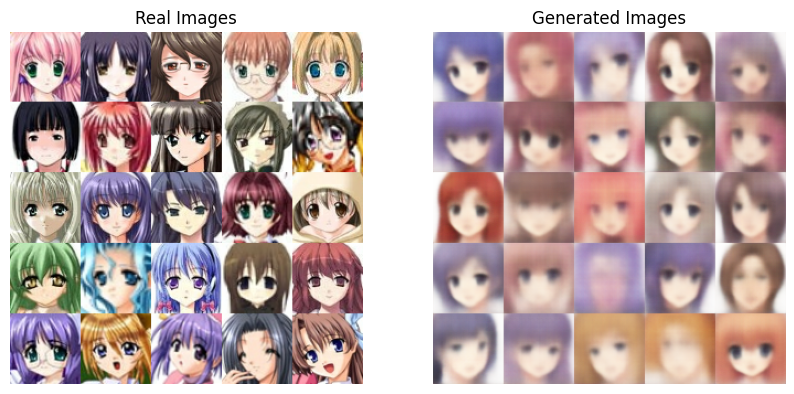

In [25]:
history = train_vae()

In [26]:
# Function to plot the losses
def plot_metrics(history, renderer=None, epochs = epochs):
  losses = history["loss"]
  list_epochs=np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name="Loss", line=dict(color="blue", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [29]:
# Interactive graphic
plot_metrics(history)

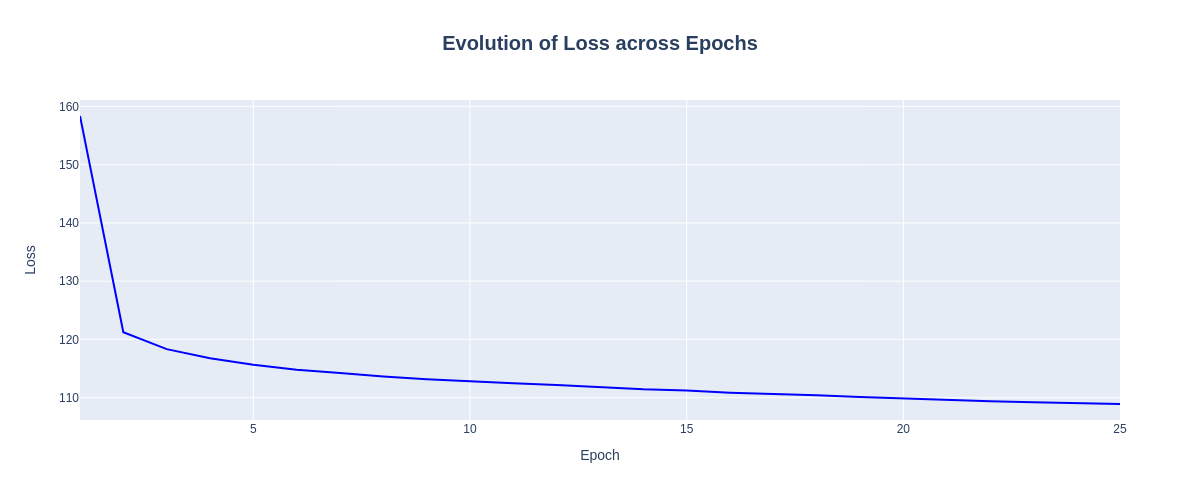

In [28]:
# Image for GitHub
plot_metrics(history, renderer="png")

**Save model VAE**

In [30]:
vae.save("/content/drive/MyDrive/models/vae_anime_faces.keras")

### **Create a GIF from the generated images**

In [31]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.5 MB/s eta 0:00:00


In [32]:
# Function to create gifs

def create_gif(gif_file, images_file, fps=1):
  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    filenames = sorted(glob.glob(f"{images_file}/*.png"))
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


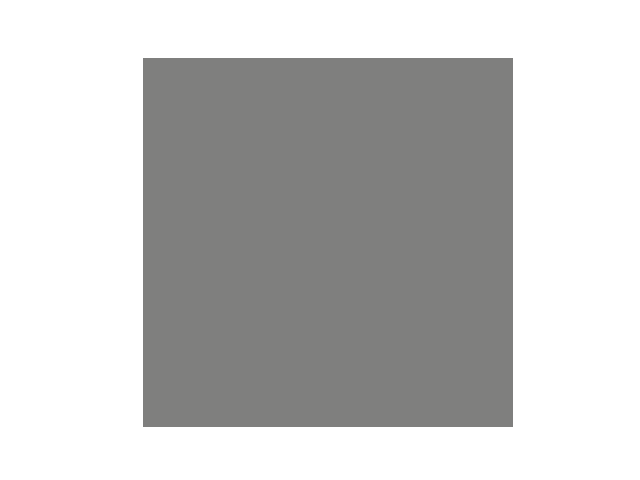

In [34]:
gif_file = os.path.join(directory_vae, "anime_faces_vae.gif")
create_gif(gif_file, directory_vae, fps=3)
embed.embed_file(gif_file)

### **Generated Examples**

**Load VAE model**

In [17]:
# Custom layer
@tf.keras.saving.register_keras_serializable()
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon
    z = tf.reshape(z, (batch, 1, 1, dim))

    return z

In [18]:
vae = tf.keras.models.load_model("/content/drive/MyDrive/models/vae_anime_faces.keras")
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 16),                 3022560   ['input_2[0][0]']             
                              (None, 16),                                                         
                              (None, 1, 1, 16)]                                                   
                                                                                                  
 decoder (Sequential)        (None, 64, 64, 3)            2891459   ['encoder[0][2]']             
                                                                                              

**Generating anime faces random noise**

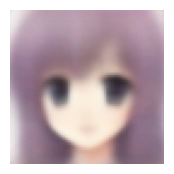

In [39]:
noise = tf.random.normal(shape=(1, 1, 1, z_dim))
generated_example = vae.get_layer("decoder")(noise)[0]
plt.figure(figsize=(2, 2))
plt.imshow(generated_example)
plt.axis("off");

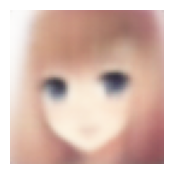

In [40]:
noise = tf.random.normal(shape=(1, 1, 1, z_dim))
generated_example = vae.get_layer("decoder")(noise)[0]
plt.figure(figsize=(2, 2))
plt.imshow(generated_example)
plt.axis("off");

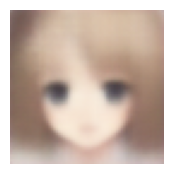

In [41]:
noise = tf.random.normal(shape=(1, 1, 1, z_dim))
generated_example = vae.get_layer("decoder")(noise)[0]
plt.figure(figsize=(2, 2))
plt.imshow(generated_example)
plt.axis("off");

**Examples of reconstructed images**

In [30]:
# Taking a batch
images = next(iter(train_dataset))
recons_images = vae(images)

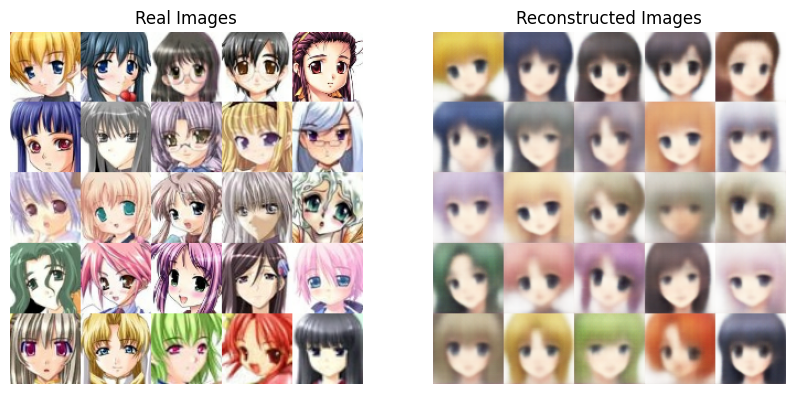

In [31]:
show_and_save_images(images, recons_images, num_examples=25,
                     nrow=5, names=["Real Images", "Reconstructed Images"])

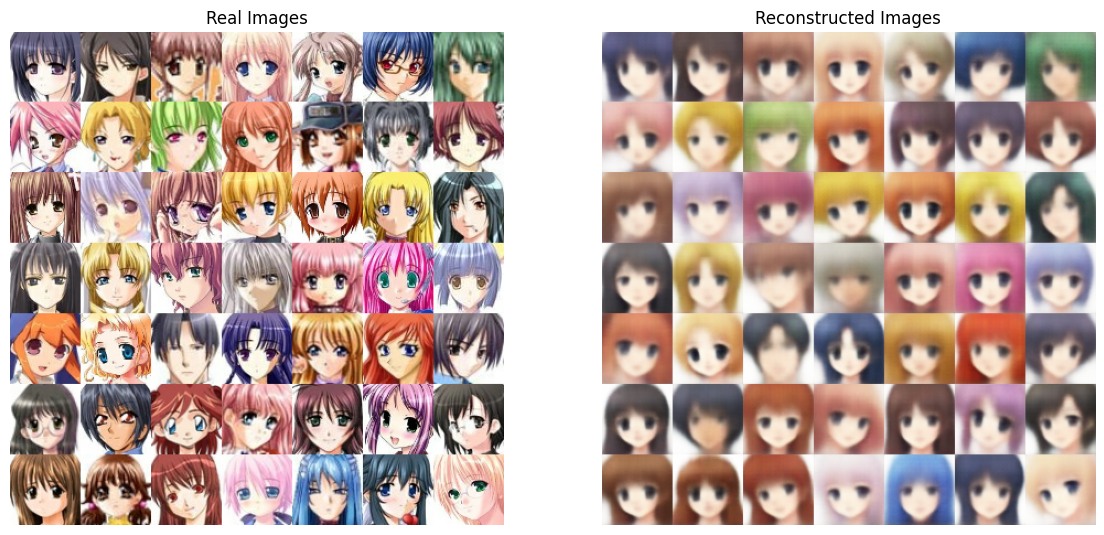

In [33]:
show_and_save_images(images, recons_images, num_examples=49, nrow=7,
                     random=True, names=["Real Images", "Reconstructed Images"])

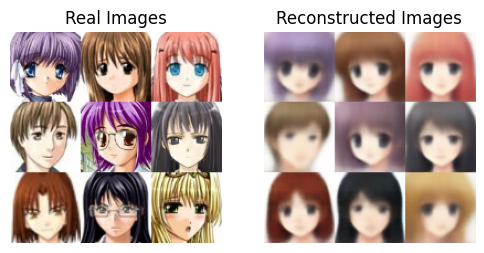

In [34]:
show_and_save_images(images, recons_images, num_examples=9, nrow=3,
                     random=True, names=["Real Images", "Reconstructed Images"])